<a href="https://colab.research.google.com/github/a945120/ColabforAI/blob/master/Dogsbreeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

!git clone https://github.com/a945120/ColabforAI.git  連接github資料夾指令

In [4]:
!git clone https://github.com/a945120/ColabforAI.git

Cloning into 'ColabforAI'...
remote: Enumerating objects: 3530, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 3530 (delta 5), reused 1 (delta 0), pack-reused 3512
Receiving objects: 100% (3530/3530), 125.61 MiB | 33.97 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (3496/3496), done.


In [1]:
#visualization
import matplotlib.pyplot as plt

#data manipulations
import numpy as np
import pandas as pd

#pytorch
import torchvision
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder


In [2]:
from PIL import Image
from collections import OrderedDict

In [5]:
#check folder is loaded
dataset = ImageFolder('/content/ColabforAI/images modify')
print('Total Images number: ',len(dataset))
print('Total Classes number: ',len(dataset.classes))

Total Images number:  3494
Total Classes number:  20


In [6]:
#rename folder
breeds = []

def rename(name):
    return ' '.join(' '.join(name.split('-')[1:]).split('_'))

for n in dataset.classes:
    breeds.append(rename(n))

print(breeds)

['Chihuahua', 'Maltese dog', 'Shih Tzu', 'papillon', 'Yorkshire terrier', 'miniature schnauzer', 'standard schnauzer', 'golden retriever', 'Labrador retriever', 'Border collie', 'German shepherd', 'Doberman', 'French bulldog', 'Siberian husky', 'Samoyed', 'Pomeranian', 'Pembroke', 'toy poodle', 'miniature poodle', 'standard poodle']


In [7]:
#random split train and test dataset
random_seed = 40
x = torch.manual_seed(random_seed)

train_num = 0.7
val_num = 0.3

train_size = int(len(dataset) * train_num)
val_size = len(dataset) - train_size

print(train_size, val_size)

2445 1049


In [8]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(len(train_dataset), len(val_dataset))

2445 1049


n02112018-Pomeranian
<class 'PIL.Image.Image'>


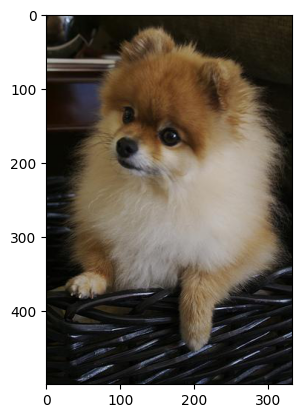

In [10]:
img, label = train_dataset[6]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))